#Import & Function

In [ ]:
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
from keras import backend as K
from sklearn.model_selection import train_test_split

import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import shutil
import itertools
import random

from numpy import asarray, load
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
from matplotlib import pyplot

from tensorflow import keras
#from tensorflow.keras import layers
from keras.models import load_model
from tensorflow.keras.metrics import MeanIoU
from os import listdir
from os.path import isfile, join
from PIL import Image
from pathlib import Path
from skimage.color import rgb2gray
from datetime import datetime 

In [ ]:
from numpy.random import seed
seed(1305)
tf.random.set_seed(1305)

In [ ]:
def flatten(listOfLists):
    "Flatten one level of nesting"
    return list(itertools.chain.from_iterable(listOfLists))

In [ ]:
def searching_all_files(directory: Path):   
    file_list = [] # A list for storing files existing in directories

    for x in directory.iterdir():
        if x.is_file():

           file_list.append(str(x))
        else:

           file_list.append(searching_all_files(directory/x))

    return file_list

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Parameters

In [ ]:
lr_generator = 0.001
beta1_generator = 0.9
beta1_discriminator = 0.5
numero_epoche = 8
numero_batch = 64


dieciEpoche = 900000
cinquantaEpoche = 900000

tanh = False
OCTA = True
OCT = False
DataAugmentation = True

#Train & Test

In [ ]:
if OCT:
  X_train = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/X_train_256_OCT_CLAHE.npy')
  X_test = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/X_test_256_OCT_CLAHE.npy')
  y_train = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/y_train_256.npy')
  y_test = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/y_test_256.npy')

elif OCTA:
  if DataAugmentation:
    X_train = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/X_train_augmented.npy')
    y_train = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/y_train_augmented.npy')
    X_test = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/X_test_augmented.npy')
    y_test = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/y_test_augmented.npy')
    X_valid = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/X_val_augmented.npy')
    y_valid = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/y_val_augmented.npy')
  else:
    X_train = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/X_train_256_OCTA_CLAHE.npy')
    X_test = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/X_test_256_OCTA_CLAHE.npy')
    y_train = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/y_train_256.npy')
    y_test = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/y_test_256.npy')

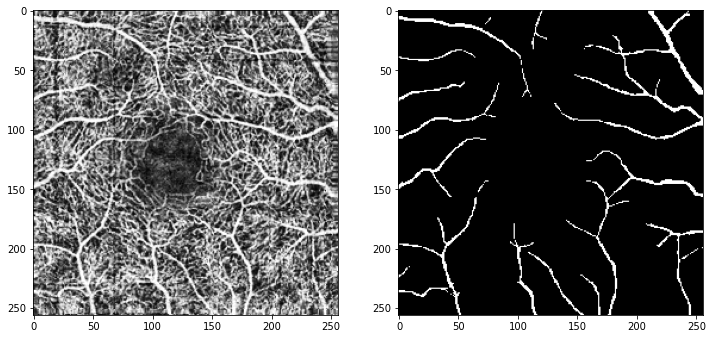

In [ ]:
#Sanity check, view few mages
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0],cmap = 'gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0],cmap = 'gray')
plt.show()

In [ ]:
#Define data
# load and prepare training images
data = [X_train, y_train]
data_test = [X_test,y_test]

In [ ]:
def preprocess_data(data):
  # load compressed arrays
  # unpack arrays
  X1, X2 = data[0], data[1]
  # scale from [0,255] to [-1,1]
  X1 = X1*255
  X2 = X2*255
  X1 = (X1 - 127.5) / 127.5
  X2 = (X2 - 127.5) / 127.5
  return [X1, X2]

if tanh:
  data = preprocess_data(data)
  data_test = preprocess_data(data_test)

#Pix2Pix

In [ ]:
def jacard_coef(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def jacard_coef_loss(y_true, y_pred):
  return -jacard_coef(y_true, y_pred)

In [ ]:
def define_discriminator(image_shape,target_shape):
    
	# weight initialization
	init = RandomNormal(stddev=0.02,seed = 1305) #As described in the original paper
    
	# source image input
	in_src_image = Input(shape=image_shape)  #Image we want to convert to another image
	# target image input
	in_target_image = Input(shape=target_shape)  #Image we want to generate after training
    
	# concatenate images, channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
    
	# C64: 4x4 kernel Stride 2x2
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128: 4x4 kernel Stride 2x2
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256: 4x4 kernel Stride 2x2
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512: 4x4 kernel Stride 2x2 
  
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer : 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
    #The model is trained with a batch size of one image and Adam opt. 
    #with a small learning rate and 0.5 beta. 
    #The loss for the discriminator is weighted by 50% for each model update.
    
	opt = keras.optimizers.Adam(learning_rate=0.0002,beta_1=beta1_discriminator)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

In [ ]:
disc_model = define_discriminator((256,256,1),(256,256,1))
#plot_model(disc_model, to_file='disc_model.png', show_shapes=True)

In [ ]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02,seed = 1305)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block to be used in generator
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02,seed = 42)
	#print("Encoding",layer_in)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	#print("Encoding_Conv",g)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	#print("Encoding_Batch",g)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
		#print("Encoding_Drop",g)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	#print("Encoding_Drop",g)
	# relu activation
	g = Activation('relu')(g)
	return g

# define the standalone generator model - U-net
def define_generator(image_shape=(256,256,1), target_shape=(256,256,1)):
	# weight initialization
	init = RandomNormal(stddev=0.02, seed = 1305)
	# image input
	in_image = Input(shape=image_shape)

	# encoder model: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	#print(b)
	b = Activation('relu')(b)
	#print(b)
	# decoder model: CD512-CD512-CD512-C512-C256-C128-C64
	d1 = decoder_block(b, e7, 512)
	#print(d1)
	d2 = decoder_block(d1, e6, 512)
	#print(d2)
	d3 = decoder_block(d2, e5, 512)
	#print(d3)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	#print(d4)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	#print(d5)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(target_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7) #Modified 
	out_image = Activation('sigmoid')(g)  #Generates images in the range 0 to 1 
	# define model
	model = Model(in_image, out_image)
	return model


In [ ]:
gen_model = define_generator((256,256,1),(256,256,1))
#plot_model(gen_model, to_file='gen_model.png', show_shapes=True)

In [ ]:
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False       #Descriminator layers set to untrainable in the combined GAN but 
                                                #standalone descriminator will be trainable.
            
	# define the source image
	in_src = Input(shape=image_shape)
	# suppy the image as input to the generator 
	gen_out = g_model(in_src)
	# supply the input image and generated image as inputs to the discriminator
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and disc. output as outputs
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = keras.optimizers.Adam(learning_rate=lr_generator,beta_1=beta1_generator)
    
    #Total loss is the weighted sum of adversarial loss (BCE) and L1 loss (MAE)
    #Authors suggested weighting BCE vs L1 as 1:100.
	model.compile(loss=['binary_crossentropy', jacard_coef_loss],optimizer=opt, loss_weights=[1,100], metrics=[jacard_coef])
	return model

In [ ]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instance

	np.random.seed(1305)
	ix = np.random.randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y


#Salvataggio modello

In [ ]:
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	
	# plot real source images
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i][:,:,0],cmap='gray')
	# plot generated target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i][:,:,0],cmap='gray')
	# plot real target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i][:,:,0],cmap='gray')
	# save plot to file
	filename1 = '/content/drive/MyDrive/Tesi magistrale/modelli_salvati/Pix2Pix/Variation/OCTA/Augmented_Pix2Pix_8_Epoche_B64_1e-3__%01d.png' % (step+1)

	plt.savefig(filename1)
	plt.close()
	# save the generator model
	filename2 = '/content/drive/MyDrive/Tesi magistrale/modelli_salvati/Pix2Pix/Variation/OCTA/Augmented_Pix2Pix_8_Epoche_B64_1e-3_%01d.hdf5' % (step+1)
	g_model.save(filename2)
	print('Saved')

In [ ]:
# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1, dieciEpoche=120, cinquantaEpoche=600):
  # determine the output square shape of the discriminator
  n_patch = d_model.output_shape[1] #16
  # unpack dataset
  trainA, trainB = dataset
  # calculate the number of batches per training epoch
  bat_per_epo = int(len(trainA) / n_batch)
  # calculate the number of training iterations
  n_steps = bat_per_epo * n_epochs
  # manually enumerate epochs
  for i in range(n_steps):
    # select a batch of real samples
    [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
    # generate a batch of fake samples
    X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
    # update discriminator for real samples
    d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
    # update discriminator for generated samples
    d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
    # update the generator
    g1_loss, g2_loss, g3_loss, g4_loss, g5_loss = gan_model.train_on_batch(X_realA, [y_real, X_realB])
    
    if ((i+1) % (bat_per_epo * 2) == 0) or ((i+1)==dieciEpoche) or((i+1)==cinquantaEpoche):
      print('>%d, d1[%.3f] d2[%.3f] g1[%.3f] g2[%.3f] g3[%.3f] g4[%.3f] g5[%.3f]' % (i+1, d_loss1, d_loss2, g1_loss, g2_loss, g3_loss, g4_loss, g5_loss))
      summarize_performance(i, g_model, dataset) 

#Train model 

In [ ]:
image_shape = X_train[0].shape
target_shape = y_train[0].shape

In [ ]:
image_shape

(256, 256, 1)

In [ ]:
d_model = define_discriminator(image_shape,target_shape)
g_model = define_generator(image_shape,target_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)

In [ ]:
start1 = datetime.now() 

train(d_model, g_model, gan_model, data, n_epochs=numero_epoche, n_batch=numero_batch, dieciEpoche=dieciEpoche, cinquantaEpoche=cinquantaEpoche) 

stop1 = datetime.now()
#Execution time of the model 
execution_time = stop1-start1
print("Execution time is: ", execution_time)

>60, d1[0.358] d2[0.395] g1[-58.549] g2[1.259] g3[-0.598] g4[0.293] g5[0.598]
Saved
>120, d1[0.313] d2[0.334] g1[-80.455] g2[1.105] g3[-0.816] g4[0.340] g5[0.816]
Saved
>180, d1[0.296] d2[0.319] g1[-89.518] g2[1.062] g3[-0.906] g4[0.357] g5[0.906]
Saved
>240, d1[0.233] d2[0.265] g1[-92.546] g2[1.125] g3[-0.937] g4[0.331] g5[0.937]
Saved
Execution time is:  0:09:50.353327


#Results

In [ ]:
model = load_model('/content/drive/MyDrive/Tesi magistrale/modelli_salvati/Pix2Pix/Variation/OCTA/Augmented_Pix2Pix_8_Epoche_B64_1e-3_60.hdf5')

In [ ]:
threshold = 0.5
[X_test, y_test] = data_test
y_pred = model.predict(X_test)
y_pred_thresholded = y_pred > threshold

In [ ]:
#____________ MEAN IOU__________________
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.75312567


In [ ]:
#_____________ IOU____________________
intersection = np.logical_and(y_test,y_pred_thresholded)
union=np.logical_or(y_test,y_pred_thresholded)
iou_score = np.sum(intersection)/np.sum(union)
print("IoU score is:",iou_score)

IoU score is: 0.5397536028234371


In [ ]:
#_____________ DICE____________________
intersection = np.logical_and(y_test,y_pred_thresholded)
union=np.logical_or(y_test,y_pred_thresholded)
dice_score = (2*np.sum(intersection))/(np.sum(union)+np.sum(intersection))
print("Dice score is:", dice_score)

Dice score is: 0.7010908782206375


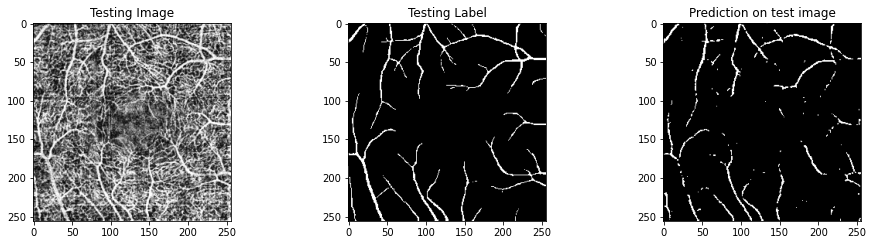

In [ ]:
test_img_number = random.randint(0, len(X_test)-1)
#test_img_number = 1
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > threshold).astype(np.uint8)


plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)

plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

#Overlapping

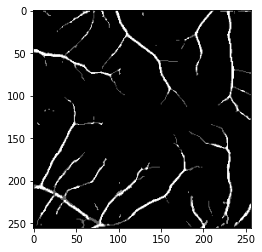

In [ ]:
fig, ax = plt.subplots()
ax.imshow(ground_truth[:,:,0], cmap='gray')
ax.imshow(prediction,cmap='gray', alpha=0.6)
fig.show()

# Plot all test images

In [ ]:
def plot_images(test_images, ground_truth, prediction, i):
  plt.figure()
  i = i+1
  titolo = 'Testing Image '+str(i)
  plt.title(titolo)
  plt.imshow(test_img[:,:,0], cmap='gray')
  plt.show()

def plot_overlapping(ground_truth, prediction, i):
  fig, ax = plt.subplots()
  ax.imshow(ground_truth[:,:,0], cmap='gray')
  ax.imshow(prediction,cmap='gray', alpha=0.6)
  i = i+1
  titolo = 'Masks Overlapping '+str(i)
  ax.set_title(titolo)
  fig.show() 

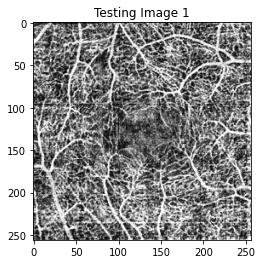

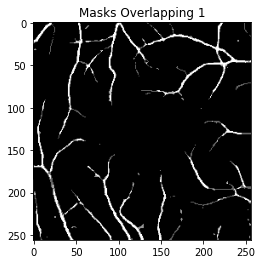

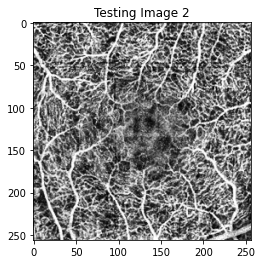

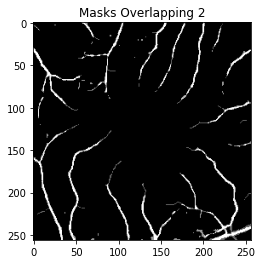

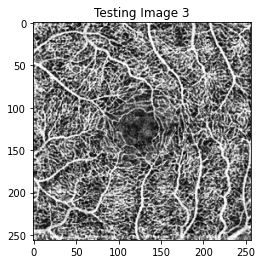

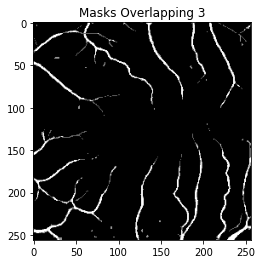

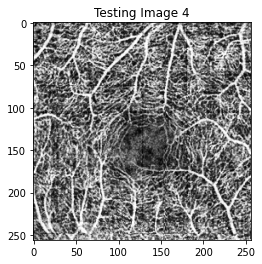

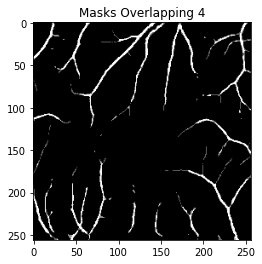

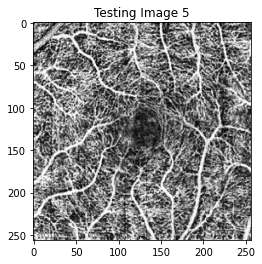

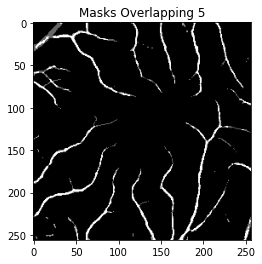

In [ ]:
for i in range(5):
  test_img_number = i
  test_img = X_test[test_img_number]
  ground_truth=y_test[test_img_number]
  test_img_input=np.expand_dims(test_img, 0)
  prediction = (model.predict(test_img_input)[0,:,:,0] > threshold).astype(np.uint8)
  
  plot_images(test_img, ground_truth, prediction, i)
  plot_overlapping(ground_truth, prediction, i)